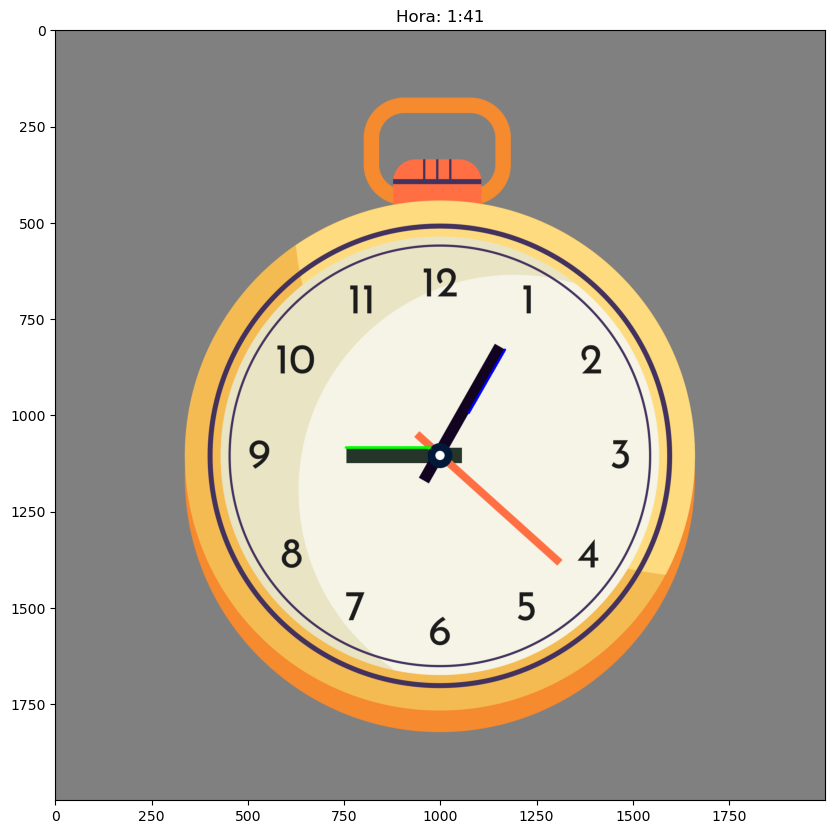

In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


imagen_bgr = cv2.imread('Clock.png')
imagen_rgb = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2RGB)

gris = cv2.cvtColor(imagen_bgr, cv2.COLOR_BGR2GRAY)
gris = cv2.GaussianBlur(gris, (5, 5), 1)
gris = cv2.equalizeHist(gris)


bordes = cv2.Canny(gris, 50, 150)

lineas = cv2.HoughLinesP(bordes, 1, np.pi/180, threshold=80, minLineLength=50, maxLineGap=10)


centro_x = imagen_bgr.shape[1] // 2
centro_y = imagen_bgr.shape[0] // 2

def calcular_angulo(x1, y1, x2, y2):
    dist1 = np.hypot(x1 - centro_x, y1 - centro_y)
    dist2 = np.hypot(x2 - centro_x, y2 - centro_y)
    if dist1 > dist2:
        dx = x1 - centro_x
        dy = centro_y - y1
    else:
        dx = x2 - centro_x
        dy = centro_y - y2
    angulo = np.degrees(np.arctan2(dy, dx))
    angulo = (90 - angulo) % 360
    return angulo

manecillas = []
if lineas is not None:
    for linea in lineas:
        x1, y1, x2, y2 = linea[0]
        longitud = np.hypot(x2 - x1, y2 - y1)
        distancia_centro = min(np.hypot(x1 - centro_x, y1 - centro_y),np.hypot(x2 - centro_x, y2 - centro_y))
        # LINEAS CENTRO
        if distancia_centro < 100 and 40 < longitud < 300:
            angulo = calcular_angulo(x1, y1, x2, y2)
            manecillas.append({
                'puntos': (x1, y1, x2, y2),
                'longitud': longitud,
                'angulo': angulo
            })

if len(manecillas) >= 2:
    # CORTO LARGO
    manecillas.sort(key=lambda x: x['longitud'])
    horario = manecillas[0]
    minutero = manecillas[-1]
    
    hora = int((horario['angulo'] / 30) % 12)
    minutos = int((minutero['angulo'] / 6) % 60)

    fraccion_hora = (horario['angulo'] / 30) % 12
    if abs(fraccion_hora - hora) > 0.5:
        hora = (hora + 1) % 12

    imagen_resultado = imagen_rgb.copy()
    #cv2.circle(imagen_resultado, (centro_x, centro_y), 5, (0, 0, 255), -1)
    cv2.line(imagen_resultado,(horario['puntos'][0], horario['puntos'][1]),(horario['puntos'][2], horario['puntos'][3]), (0, 0, 255), 5)  # horario azul
    cv2.line(imagen_resultado,(minutero['puntos'][0], minutero['puntos'][1]),(minutero['puntos'][2], minutero['puntos'][3]),(0, 255, 0), 5)  # minutero verde

    plt.figure(figsize=(10, 10))
    plt.imshow(imagen_resultado)
    plt.title(f'Hora: {hora}:{minutos:02d}')
    plt.show()



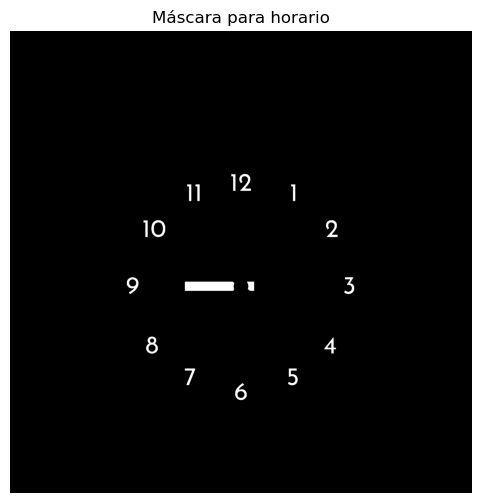

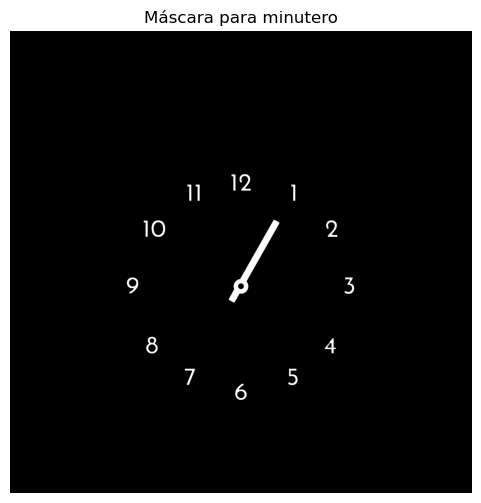

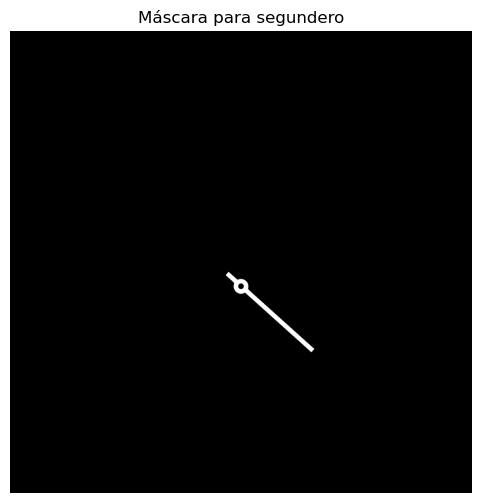

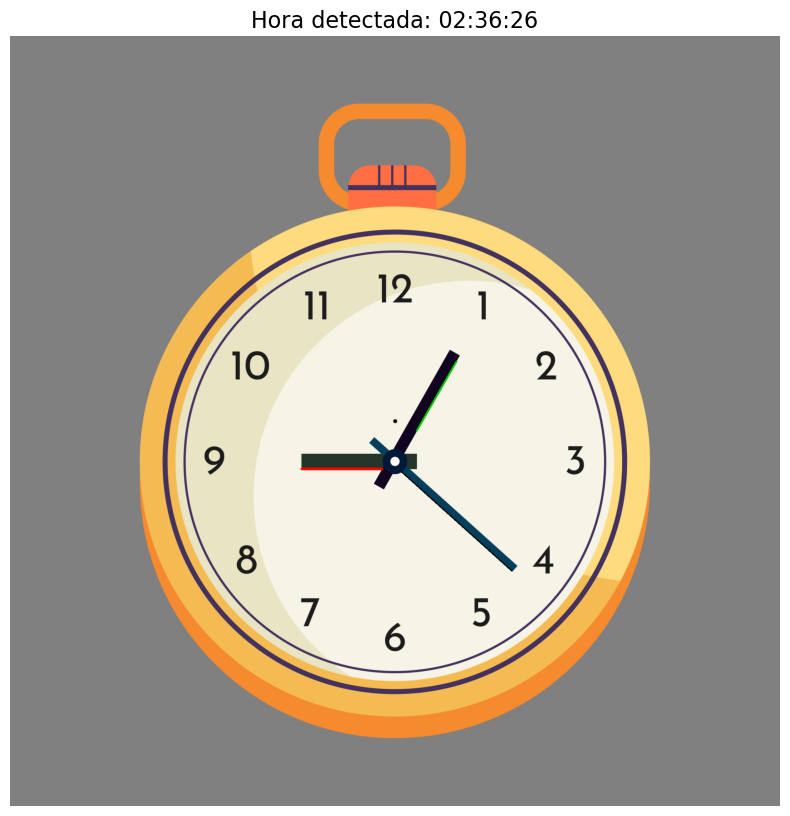

Ángulos detectados:
Horario: 79.9° → 02:36:26
Minutero: 219.1°
Segundero: 157.4°


In [57]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img_bgr = cv2.imread('Clock.png')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w = img_bgr.shape[:2]
cx, cy = w//2, h//2

horario_color = np.array([41, 53, 37])      
minutero_color = np.array([33, 3, 18])      
segundero_color = np.array([92, 63, 5])  

tolerance_horario = 30
tolerance_minutero = 25
tolerance_segundero = 40

def detectarMan(img, color, tolerance, hand_name):
    lower = np.maximum(color - tolerance, 0)
    upper = np.minimum(color + tolerance, 255)
    mask = cv2.inRange(img, lower, upper)
    
    kernel_size = 3 if hand_name != 'minutero' else 5  
    kernel = np.ones((kernel_size,kernel_size), np.uint8)
    
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    plt.figure(figsize=(6,6))
    plt.imshow(mask, cmap='gray')
    plt.title(f'Máscara para {hand_name}')
    plt.axis('off')
    plt.show()
    
    return mask

mask_hour = detectarMan(img_bgr, horario_color, tolerance_horario, 'horario')
mask_minute = detectarMan(img_bgr, minutero_color, tolerance_minutero, 'minutero')
mask_second = detectarMan(img_bgr, segundero_color, tolerance_segundero, 'segundero')

def encontrarLineas(mask, tipoManecilla):
    edges = cv2.Canny(mask, 50, 150)
    
    if tipoManecilla == 'horario':
        min_length = 50 
    elif tipoManecilla == 'minutero':
        min_length = 80  
    else:
        min_length = 100 
    
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 
                          threshold=50, 
                          minLineLength=min_length, 
                          maxLineGap=5)
    return lines

lines_hour = encontrarLineas(mask_hour, 'horario')
lines_minute = encontrarLineas(mask_minute, 'minutero')
lines_second = encontrarLineas(mask_second, 'segundero')

def calcularAngulo(x1, y1, x2, y2):
    dx1, dy1 = x1-cx, cy-y1
    dx2, dy2 = x2-cx, cy-y2
    ang1 = np.degrees(np.arctan2(dy1, dx1))
    ang2 = np.degrees(np.arctan2(dy2, dx2))
    avg_ang = (ang1 + ang2)/2
    return (90 - avg_ang) % 360

out = img_rgb.copy()
detected_hands = []
line_thickness = {'horario': 6, 'minutero': 4, 'segundero': 2}
colors = {'horario': (255, 0, 0),  
          'minutero': (0, 200, 0), 
          'segundero': (0, 0, 0)} 

for lines, hand_type in zip([lines_hour, lines_minute, lines_second], 
                          ['horario', 'minutero', 'segundero']):
    if lines is not None and len(lines) > 0:
        lines = sorted(lines, key=lambda x: np.hypot(x[0][2]-x[0][0], x[0][3]-x[0][1]), reverse=True)
        x1,y1,x2,y2 = lines[0][0]
        
        angle = calcularAngulo(x1,y1,x2,y2)
        length = np.hypot(x2-x1, y2-y1)
        
        detected_hands.append({
            'type': hand_type,
            'pts': (x1,y1,x2,y2),
            'angle': angle,
            'length': length
        })
        
        cv2.line(out, (x1,y1), (x2,y2), colors[hand_type], line_thickness[hand_type])
        cv2.circle(out, (cx, cy), 5, (0,0,0), -1)  

if len(detected_hands) == 3:
    detected_hands.sort(key=lambda x: x['length'])
    hour_data = detected_hands[0]
    minute_data = detected_hands[1]
    second_data = detected_hands[2]
    
    hour = int((hour_data['angle'] / 30) % 12)
    minute = int((minute_data['angle'] / 6) % 60)
    second = int((second_data['angle'] / 6) % 60)
    
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.title(f'Hora detectada: {hour:02d}:{minute:02d}:{second:02d}', fontsize=16)
    plt.axis('off')
    plt.show()
    
    print(f"Ángulos detectados:")
    print(f"Horario: {hour_data['angle']:.1f}° → {hour:02d}:{minute:02d}:{second:02d}")
    print(f"Minutero: {minute_data['angle']:.1f}°")
    print(f"Segundero: {second_data['angle']:.1f}°")
else:
    print(f"\nManecillas detectadas: {len(detected_hands)}/3")
    for hand in detected_hands:
        print(f"{hand['type']}: ángulo {hand['angle']:.1f}°")
    
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.title('Manecillas detectadas', fontsize=16)
    plt.axis('off')
    plt.show()
